In [72]:
import pandas as pd
import numpy as np
import cPickle as pickle
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import interp
from itertools import cycle

from sklearn import metrics
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, precision_recall_curve, average_precision_score, f1_score, accuracy_score
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.semi_supervised import label_propagation
from sklearn.naive_bayes import GaussianNB, MultinomialNB

def cross_val_roc(classifier, X, y, n_splits=3, balance=False, test_size=0.25):
    # Run classifier with cross-validation and plot ROC curves
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)

    colors = cycle(['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange'])
    lw = 2
    plt.clf()
    plt.figure(figsize=(8,6));
    
    if balance:
        splits = StratifiedShuffleSplit(y, n_splits, test_size=test_size)
    else:
        splits = StratifiedKFold(n_splits=n_splits).split(X, y)
    
    i = 0
    for (train, test), color in zip(splits, colors):
        X_train, X_test = X.ix[train], X.ix[test]
        y_train, y_test = y.ix[train], y.ix[test]
        if balance:
            X_train, y_train = balance_train_index(X_train, y_train)
        
        probas_ = classifier.fit(X_train, y_train).predict_proba(X_test)
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=lw, color=color,
                 label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

        i += 1
    plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k',
             label='Luck')

    mean_tpr /= n_splits
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, color='g', linestyle='--',
             label='Mean ROC (area = %0.2f)' % mean_auc, lw=lw)

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show();

def cv_score(clf, X, y, cv=5, scoring='f1'):
    print scoring + ' cross validation score: ' + str(np.mean(cross_val_score(rf, X, y, cv=cv, scoring=scoring)))
    
def combine_and_balance_dfs(df1, df2, minority_fraction=0.5, ignore_index=True):
    if df1.shape[0] > df2.shape[0]:
        df1, df2 = df2, df1
    m = int(df1.shape[0]*(1.0/minority_fraction - 1))
    if m > df2.shape[0]:
        print 'majority df too small to achieve desired minority fraction'
        m = df2.shape[0]
    return df1.append(df2.sample(m), ignore_index=ignore_index)

def balance_train_index(X_train, y_train):
    pos_index = y_train[y_train == 1].index
    neg_index = y_train[y_train == 0].index
    reduced_neg_index = np.random.choice(neg_index, pos_index.shape[0], replace=False)
    b_index = pos_index.tolist() + reduced_neg_index.tolist()
    return X_train.ix[b_index], y_train.ix[b_index]

#Balances training split but not testing split
def balanced_train_test_split(X, y, test_size=0.5):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, y_train = balance_train_index(X_train, y_train)
    return X_train, X_test, y_train, y_test

def plot_precision_recall_curve(y_true, y_pred_probas, baseline=0):
    precision, recall, _ = precision_recall_curve(y_true, y_pred_probas)
    avg_precision = average_precision_score(y_true, y_pred_probas)
    plt.clf();
    plt.figure(figsize=(8,6));
    plt.plot(recall, precision, color='navy', label='Precision-Recall curve');
    plt.plot([0, 1], [baseline, baseline], linestyle='--', label='Baseline')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall example: AUC={0:0.2f}'.format(avg_precision))
    plt.legend(loc="lower left")
    plt.show();

In [61]:
non_allergen_fp = 'pickles/ah_non_allergen_df_with_features.pkl'
allergen_fp = 'pickles/ah_allergen_df_with_features.pkl'

with open(non_allergen_fp, 'r') as fin:
    non_allergen_df = pickle.load(fin)
with open(allergen_fp, 'r') as fin:
    allergen_df = pickle.load(fin)

df = allergen_df.append(non_allergen_df, ignore_index=True)
balanced_df = combine_and_balance_dfs(allergen_df, non_allergen_df, minority_fraction=0.5)

In [62]:
percents = [0.003, 0.004, 0.006, 0.008, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4]
percent_dfs = []
for p in percents:
    percent_dfs.append(combine_and_balance_dfs(allergen_df, non_allergen_df, minority_fraction=p))

majority df too small to achieve desired minority fraction
majority df too small to achieve desired minority fraction
majority df too small to achieve desired minority fraction
majority df too small to achieve desired minority fraction
majority df too small to achieve desired minority fraction
majority df too small to achieve desired minority fraction
majority df too small to achieve desired minority fraction


In [63]:
sdf = df.sample(10000).reset_index(drop=True)

In [64]:
def print_df_ratio(df):
    print df[df['allergen'] == 1].shape[0]*1.0/df.shape[0]
    
print_df_ratio(df)
print_df_ratio(sdf)
for percent_df in percent_dfs:
    print_df_ratio(percent_df)

0.105411103303
0.1039
0.105411103303
0.105411103303
0.105411103303
0.105411103303
0.105411103303
0.105411103303
0.105411103303
0.2
0.3
0.4


In [65]:
print percent_dfs[0].shape, df.shape

(11384, 30) (11384, 30)


## balanced versus unbalanced training

In [67]:
rf = RandomForestClassifier()
gb = GradientBoostingClassifier()
classifiers = [rf]



('0.105411103303', ' percent df')
balanced training data:  True
RandomForestClassifier
f1 score:  0.474611398964


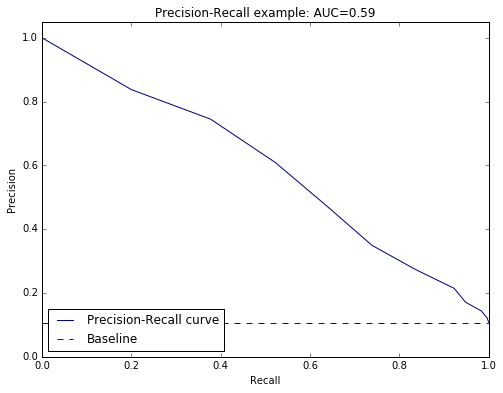

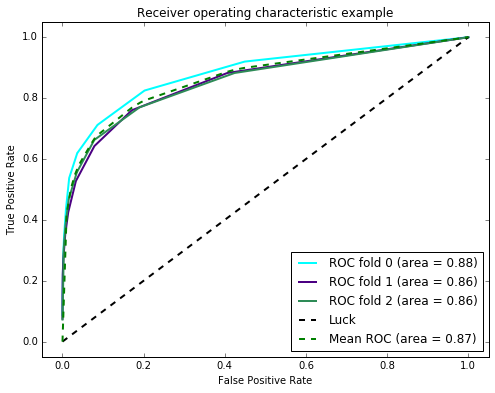






('0.105411103303', ' percent df')
balanced training data:  False
RandomForestClassifier
f1 score:  0.527942925089


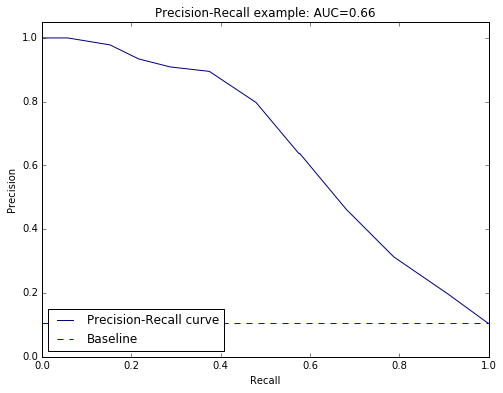

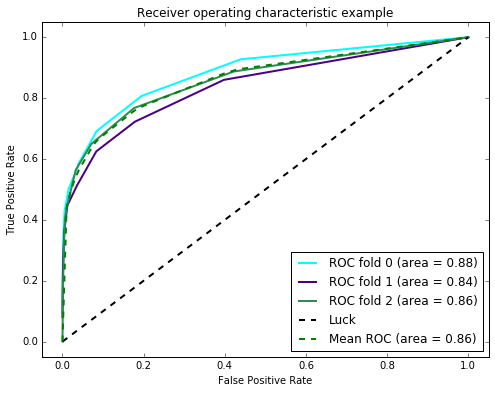






('0.105411103303', ' percent df')
balanced training data:  True
RandomForestClassifier
f1 score:  0.469854469854


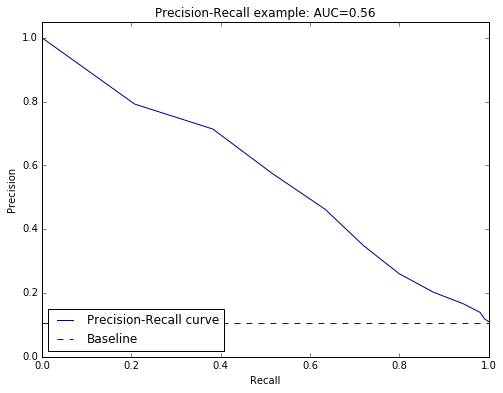

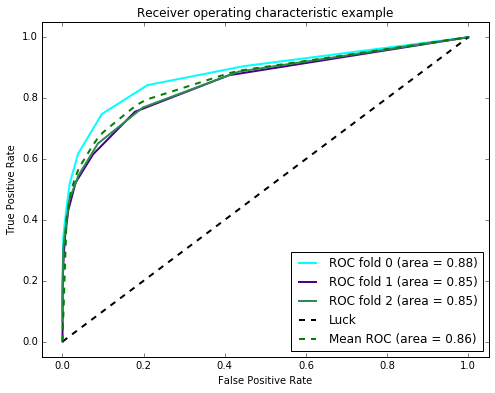






('0.105411103303', ' percent df')
balanced training data:  False
RandomForestClassifier
f1 score:  0.511363636364


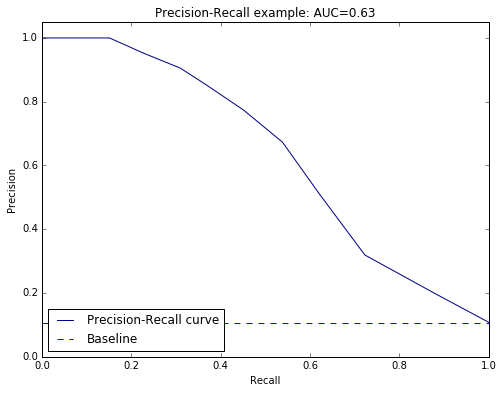

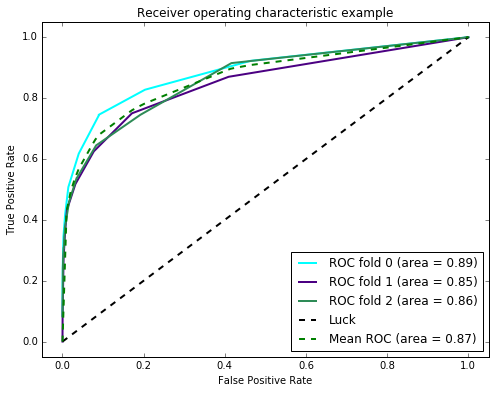






('0.105411103303', ' percent df')
balanced training data:  True
RandomForestClassifier
f1 score:  0.458015267176


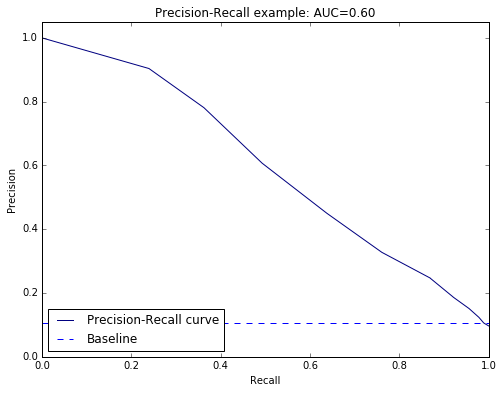

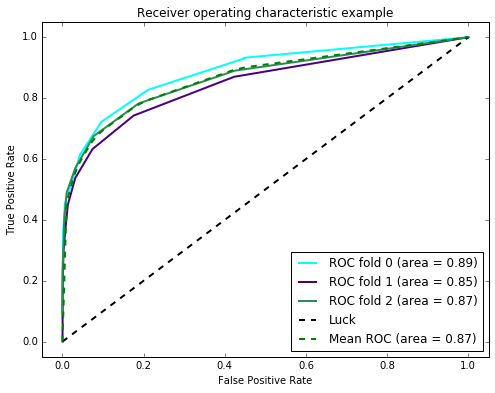






('0.105411103303', ' percent df')
balanced training data:  False
RandomForestClassifier
f1 score:  0.497055359246


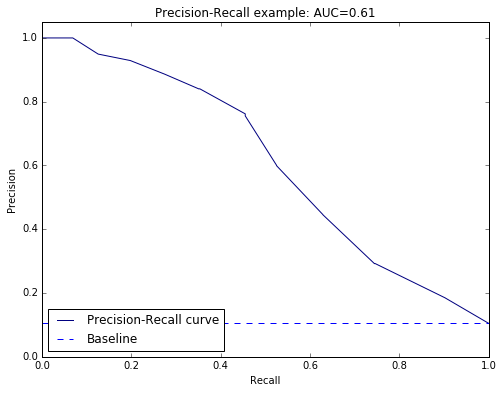

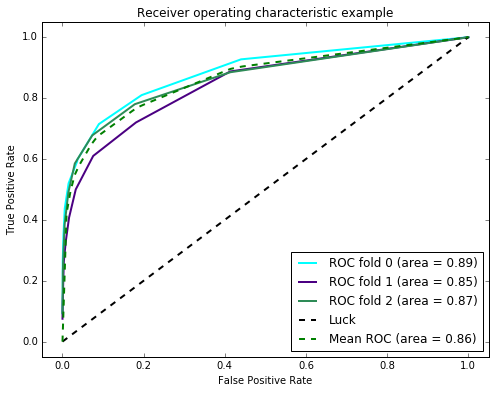






('0.2', ' percent df')
balanced training data:  True
RandomForestClassifier
f1 score:  0.57938718663


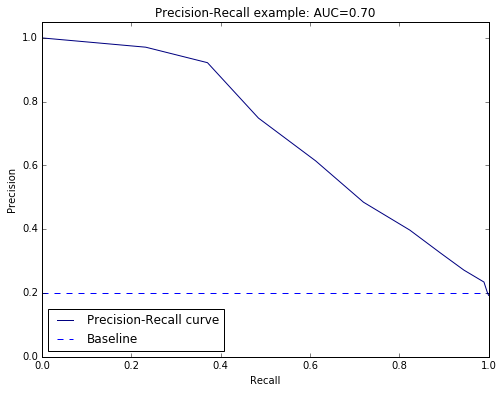

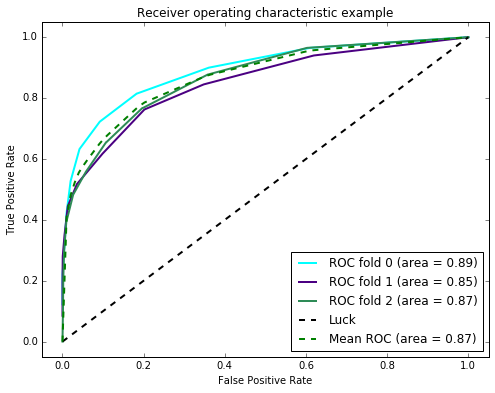






('0.2', ' percent df')
balanced training data:  False
RandomForestClassifier
f1 score:  0.584551148225


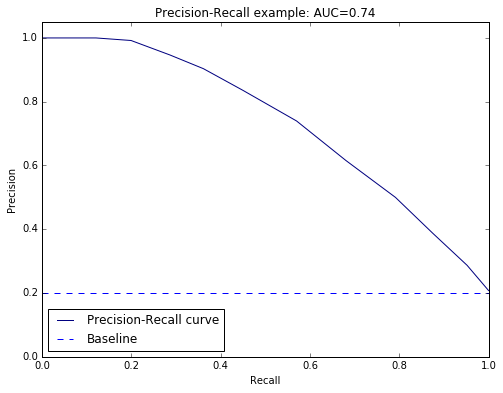

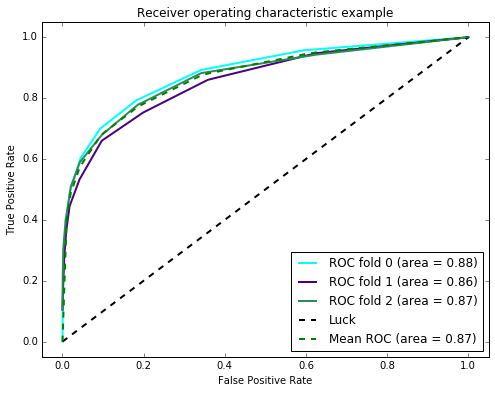






('0.3', ' percent df')
balanced training data:  True
RandomForestClassifier
f1 score:  0.694316436252


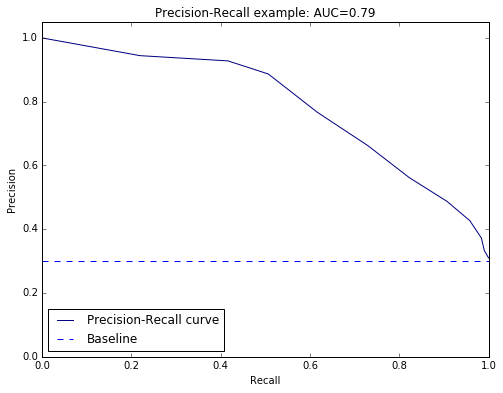

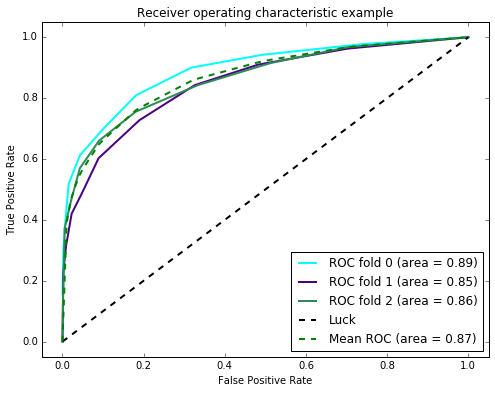






('0.3', ' percent df')
balanced training data:  False
RandomForestClassifier
f1 score:  0.655172413793


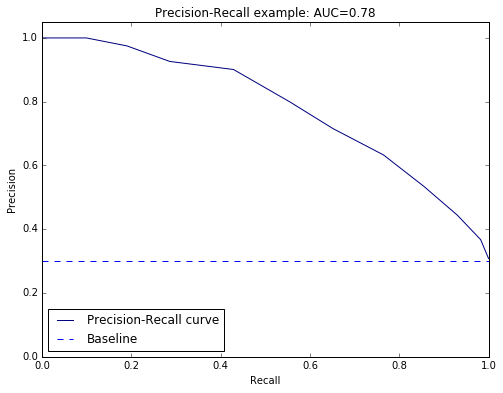

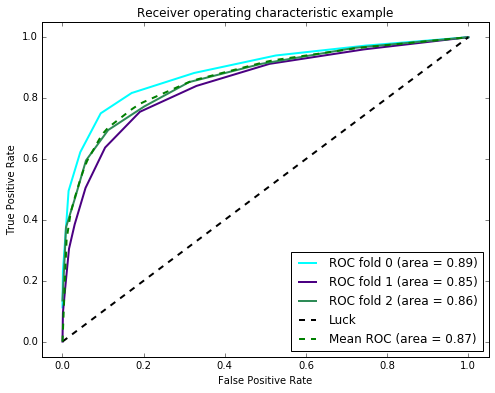






('0.4', ' percent df')
balanced training data:  True
RandomForestClassifier
f1 score:  0.728205128205


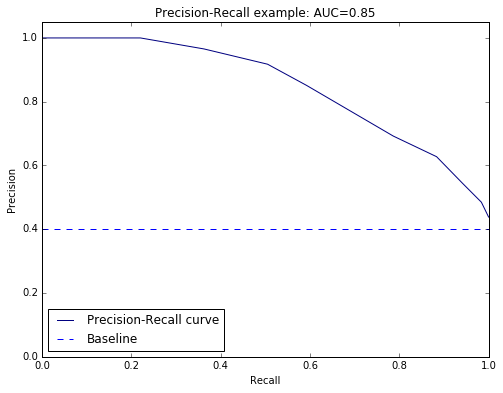

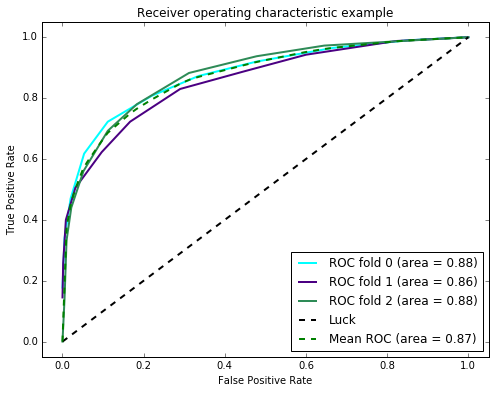






('0.4', ' percent df')
balanced training data:  False
RandomForestClassifier
f1 score:  0.73731884058


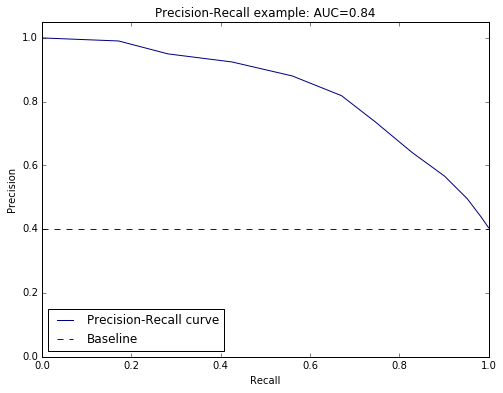

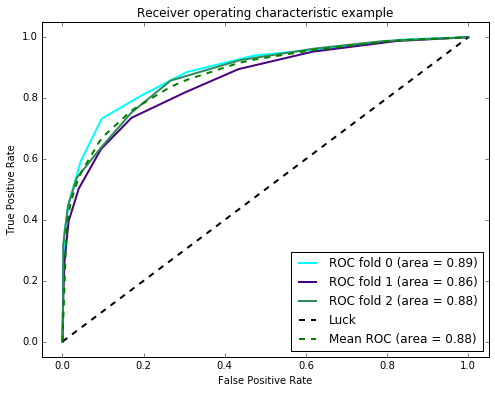

In [73]:
X = balanced_df.drop(['sequence','allergen'], axis=1)
y = balanced_df['allergen']
m = 'balanced df'

tests = [(X, y, m)]

for percent_df in percent_dfs[4:]:
    X = percent_df.drop(['sequence','allergen'], axis=1)
    y = percent_df['allergen']
    m = str(percent_df[percent_df['allergen'] == 1].shape[0]*1.0/percent_df.shape[0]), ' percent df'
    tests.append((X, y, m))


for X, y, m in tests[1:]:
    for clf in classifiers:
        for balance in [True, False]:
            print '\n\n', m
            print 'balanced training data: ', str(balance)
            print str(clf).split('(')[0]
            if balance:
                X_train, X_test, y_train, y_test = balanced_train_test_split(X, y, test_size=.25)
            else:
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5)
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            y_pred_proba = clf.predict_proba(X_test)
            print 'f1 score: ', f1_score(y_test, y_pred)
            plot_precision_recall_curve(y_test, y_pred_proba[:, 1], baseline=m[0])
            cross_val_roc(clf, X, y)
            print '\n\n'

(10000, 28) (10000, 30) (10000,)
f1 score:  0.464500601685 



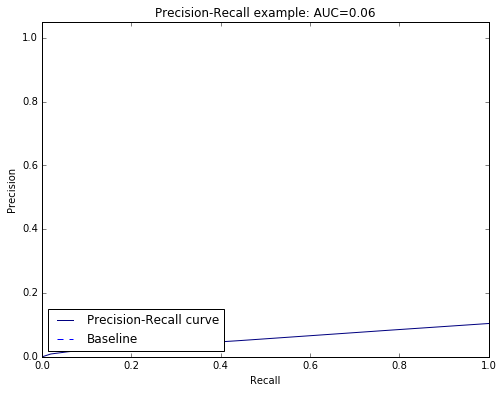

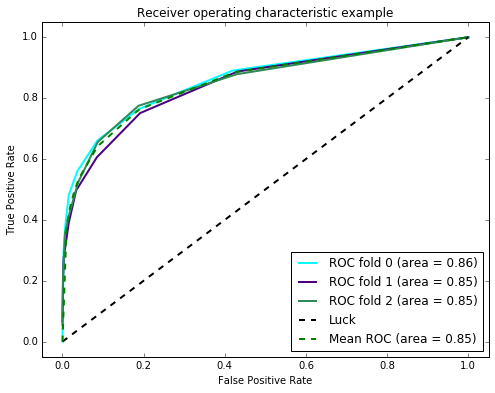

In [74]:
X = sdf.drop(['sequence','allergen'], axis=1).copy()
y = sdf['allergen'].copy()
print X.shape, sdf.shape, y.shape
for clf in classifiers:
    X_train, X_test, y_train, y_test = balanced_train_test_split(X, y, test_size=.25)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test)
    print 'f1 score: ', f1_score(y_test, y_pred), '\n'
    plot_precision_recall_curve(y_test, y_pred_proba[:, 0])
    cross_val_roc(clf, X, y)
    print '\n\n'

## One class SVM

# forgot to scale data!

In [ ]:
X = sdf.drop(['sequence','allergen'], axis=1).copy()
y = sdf['allergen'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5)
X_train = X_train[y_train == 1];
y_train = y_train[y_train == 1]

X_unlabeled = X_test[y_test == 0]
y_unlabeled = y_test[y_test == 0]

ss = StandardScaler(with_mean=False)
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)
X_unlabeled = ss.transform(X_unlabeled)

clf = svm.OneClassSVM(nu=0.2, kernel="rbf", gamma=0.0009765625)
clf.fit(X_train)

y_pred_train = clf.predict(X_train)
y_train_scores = clf.decision_function(X_train)
y_pred_test = clf.predict(X_test)
y_test_scores = clf.decision_function(X_test)
n_error_train = y_pred_train[y_pred_train == -1].size

y_pred_unlabeled = clf.predict(X_unlabeled)
y_unlabeled_scores = clf.decision_function(X_unlabeled)

y_pred_unlabeled_pos = y_pred_unlabeled[y_pred_unlabeled == 1]
y_pred_unlabeled_pos_prop = y_pred_unlabeled_pos.shape[0]*1.0/y_pred_unlabeled.shape[0]

print 'training size: ', X_train.shape[0]
# print 'test size', X_test.shape[0]
# print 'unlabeled size: ', X_unlabeled.shape[0]
print 'train error proportion: ', 1.0*n_error_train/X_train.shape[0]
print 'unlabeled positive proportion: ', y_pred_unlabeled_pos_prop

#doesn't do anything if both y_train and y_test are all positives
y_test = y_test.apply(lambda x: -1.0 if x == 0 else 1.0)
y_train = y_train.apply(lambda x: -1.0 if x == 0 else 1.0)

print classification_report(y_test, y_pred_test)
plot_precision_recall_curve(y_test, y_test_scores)

In [ ]:
X = sdf.drop(['sequence','allergen'], axis=1).copy()
y = sdf['allergen'].copy()
clf = svm.OneClassSVM(nu=0.10, kernel="rbf", gamma=0.1)
parameters = {'kernel':('rbf',), 'nu':[0.001, 0.01, 0.1, 0.2, 0.4, 0.6], 'gamma': [2**(-10), 2**(-5), 0.1, 1, 2, 8]}
gs_clf = GridSearchCV(clf, parameters, scoring='f1')
gs_clf.fit(X, y)
print gs_clf.best_score_, gs_clf.best_params_

## Semi-Supervised Learning

### label prop

In [ ]:
X = sdf.drop(['sequence','allergen'], axis=1).copy()
y = sdf['allergen'].copy()
unlabeled_set = y == 0
y_train = y.copy()
y_train[unlabeled_set] = -1
print X.shape, y_train.shape, unlabeled_set.shape, y_train[y_train == 1].shape

# lp_model = label_propagation.LabelSpreading(gamma=0.25, max_iter=5)
lp_model = label_propagation.LabelPropagation()
lp_model.fit(X, y_train)
predicted_labels = lp_model.predict_proba(X)
true_labels = y[unlabeled_set]

cm = confusion_matrix(true_labels, predicted_labels, labels=lp_model.classes_)

print("Label Spreading model: %d labeled & %d unlabeled points (%d total)" %
      (n_labeled_points, n_total_samples - n_labeled_points, n_total_samples))

print(classification_report(true_labels, predicted_labels))

print("Confusion matrix")
print(cm)

### two-step

In [ ]:
from sklearn.neighbors.nearest_centroid import NearestCentroid
nc = NearestCentroid(metric='cosine', shrink_threshold=0.2)
X = sdf.drop(['sequence','allergen'], axis=1).copy()
y = sdf['allergen'].copy()

nc.fit(X, y)
pred = nc.

## Ensemble

# Naive Bayes

In [87]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.pipeline import Pipeline

clf = Pipeline([('vect', TfidfVectorizer(analyzer='char', ngram_range=(1,4))), ('nb', MultinomialNB())])
X = balanced_df['sequence'].copy()
y = balanced_df['allergen'].copy()

# vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(1,3))
# X = vectorizer.fit_transform(X)

In [88]:
print cross_val_score(clf, X.toarray(), y, cv=3, scoring='f1')

AttributeError: 'Series' object has no attribute 'toarray'

In [82]:
sdf[sdf['allergen'] == 1].shape[0]*1.0/ sdf.shape[0]

0.0037